<a href="https://colab.research.google.com/github/argennof/M_Predi_Lluvias_Extremas_10/blob/main/Resultados_p3/TP3_Balbuena_Serrantes_Fonnegra_Velazquez_87466_mj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP3: Introducción al aprendizaje automático

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.

# Respuesta //:

Para el desarrollo de este TP realizamos la siguiente metodología:

# 1)
Nota 1:
Previamente construimos algunas bases de datos correspondientes algunas curadas y sin datos ausentes: 

- Marcos Juarez - 87466 - 1967-12-31/2019-05-31 - 600 registros
(omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,helio,hr,hr_max/mes,hr_min/mes,prcp_PMDA,prcp_PTA,pres_est,td,tmax,tmed,tmin,vmax_f,vmed)

- Marcos Juarez - 87467 - 1967-01-31/2020-01-31 - 580 registros (omm_id,hydro_year,Date,helio,hr,hr_max/mes,hr_min/mes,nub,prcp_PMDA,prcp_PTA,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed)

- La Florida - 1 - 1958-01-31/2019-12-31 - 709 registros (omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f) 

- Darksky: (omm_id,hydro_year,Date,prcp_PTA,prcp_PMDA,tmax,vmax_f,hr_max/mes,hr,pres_est,tmed,hr_min/mes,tmin)  - 2020-12-31/ para las tres estaciones...

- Una final con todos los registros pero reducida en variables en la que coincidian las tres estaciones... (omm_id,hydro_year,Date,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f) con 2259 registros. 

## En esta notebook exploraremos los resultados de Marcos Juarez - 87466 dado que era la que mayor cantidad de variables presentaba.


      Procedimiento en Python - Imputando Datos:
          








1- Configuración de las librerías necesarías para el desarrollo del trabajo:

In [1]:
import warnings
warnings.filterwarnings("ignore")

## For data
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)

## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

- Carga de datos todas las estaciones incluidos los datos de Marcos Juarez 87466 - Mensuales:

In [2]:
mj_87466 = pd.read_csv("https://github.com/argennof/M_Predi_Lluvias_Extremas_10\
/blob/main/BBDD_clean_tc_dc_ch/final_87466_mj.csv?raw=true", sep=';', parse_dates = True)

df = mj_87466.copy()
df.insert(0, 'id', np.arange(len(df)))
df['Date'] = pd.to_datetime(df['Date'])
df.head(3)

,id,omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,helio,hr,...,hr_min/mes,prcp_PMDA,prcp_PTA,pres_est,td,tmax,tmed,tmin,vmax_f,vmed
0,0,87466,1967,1967-12-31,701.0,126.0,1.94,283.8,9.76,50.94,...,39.0,17.0,66.9,18.98,14.95,39.0,23.55,8.1,3.92,3.59
1,1,87466,1967,1968-01-31,806.0,98.0,1.07,278.5,8.87,54.68,...,35.0,56.8,132.1,18.87,14.45,36.2,21.85,7.5,4.12,3.19
2,2,87466,1967,1968-02-29,775.0,81.0,-1.99,252.6,8.91,54.83,...,37.0,26.5,79.5,19.64,14.79,37.2,22.60,8.0,3.59,2.91


- Confirmamos los datos vacios que nos quedamos solo con los registros completos de PMDA y PTA

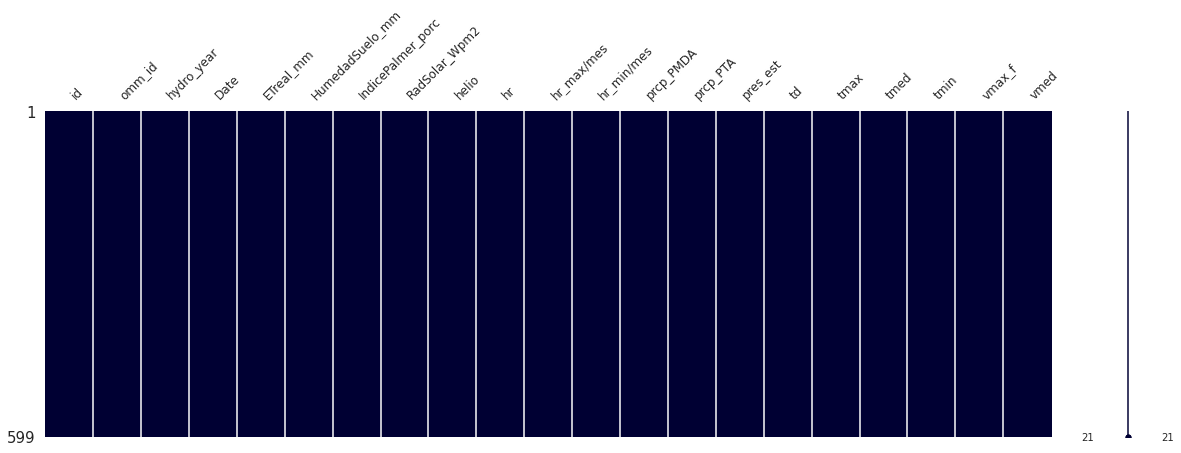

In [3]:
import missingno as msno
msno.matrix(df,figsize=(20, 6), fontsize=12, color=[0,0,0.2])



      Análisis de Series Temporales...

Pero antes de comenzar un poco de contexto ->

# [Serie Temporal](https://www.kaggle.com/code/cesarg/taller-en-moldeamiento-series-de-tiempo):

Una [serie de tiempo](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/TimeSeriePy.ipynb) o serie temporal es una secuencia de datos, observaciones o valores, medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales o desiguales. O dicho de otra manera `Conjunto de observaciones sobre los valores de una variable en diferentes momentos`.

Estas presentan algunos comportamientos como:

- Como su nombre lo indica son `dependientes del tiempo`.

- Tendencia: Se refiere al patrón de crecimiento o declinación.

- Estacionalidad: Se refiere a un patrón regularmente recurrente a través del tiempo (trimestres, mes o semana)

- Aleatoridad: Este comportamiento irregular está compuesto por fluctuaciones causadas por sucesos impredecibles o no periódicos.

-  Estacionaria: Es aquella serie de datos cuyas propiedades estadísticas básica, como media y la varianza, permanecen constantes en el tiempo, se dice que una serie que no presenta crecimiento o declinación es estacionaria.

Suelen estar `autocorrelacionadas`: la mayoría de los procesos físicos presentan una inercia y no cambian tan rápidamente. Esto, combinado con la frecuencia del muestreo, a menudo hace que las observaciones consecutivas estén correlacionadas. Esta correlación entre observaciones consecutivas se llama autocorrelación. `Cuando los datos están autocorrelacionados, la mayoría de los métodos estadísticos estándares basados en la suposición de observaciones independientes pueden arrojar resultados engañosos o incluso ser inútiles`.



      Visualizando las series de tiempo

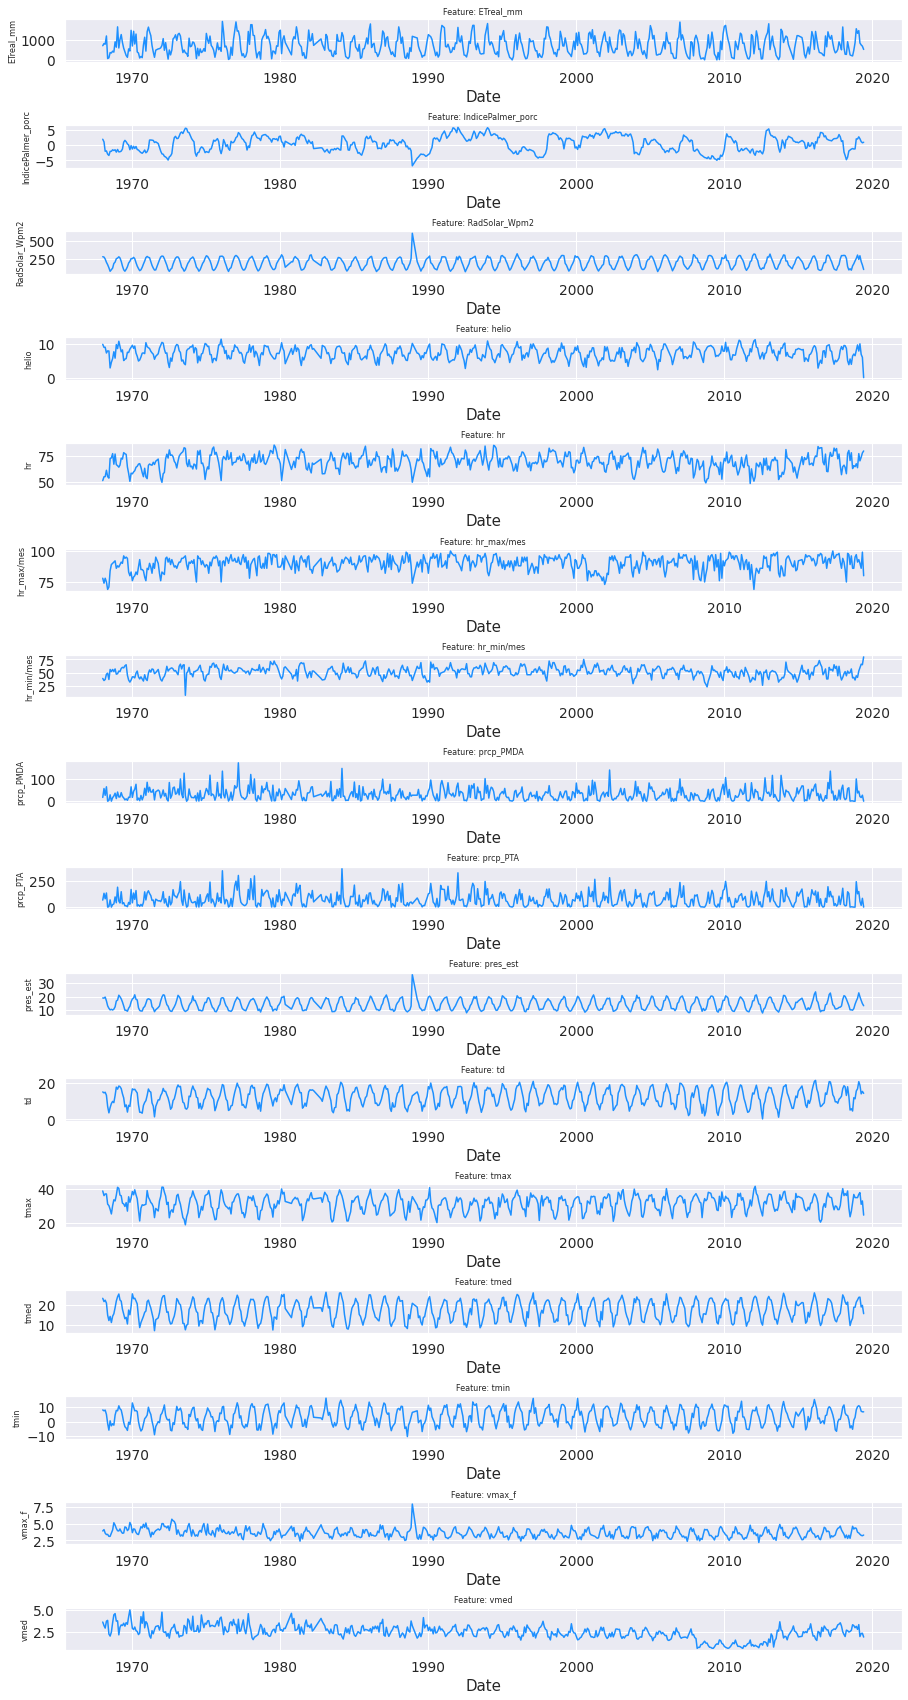

In [4]:
from datetime import datetime, date 

f, ax = plt.subplots(nrows=16, ncols=1, figsize=(15, 30))
plt.subplots_adjust(hspace=1.5)
excepto=['id','hydro_year','Date','HumedadSuelo_mm', 'omm_id','pres_est_max','pres_est_min','pres_est_prom']

for i, column in enumerate(df.columns.difference(excepto)):
    sns.lineplot(x=df['Date'], y=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=8)
    ax[i].set_ylabel(ylabel=column, fontsize=8)
    # ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])


- Filtramos las series de PMDA y PTA, para ver el comportamiento de sus datos, para esto usaremos graficos de histogramas y boxplots.

In [5]:
ts_PMDA = df.groupby('Date')['prcp_PMDA'].sum() # serie con datos atípicos PMDA
ts_PTA = df.groupby('Date')['prcp_PTA'].sum() # serie con datos atípicos PTA


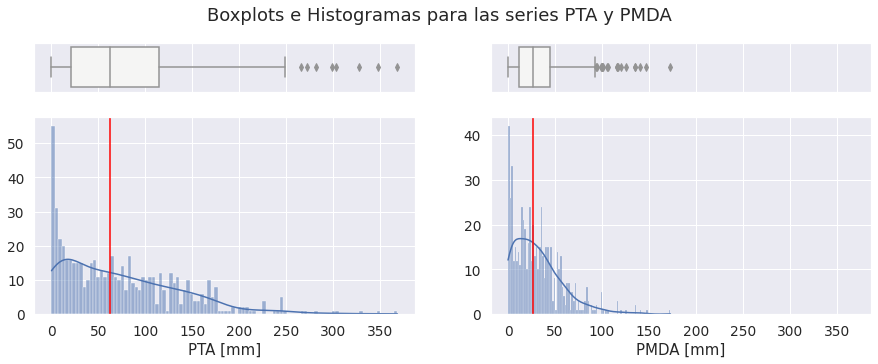

In [6]:
import seaborn as sns
f, ax = plt.subplots(2,2,
                     sharex=True,
                     gridspec_kw={"height_ratios": (.2, .8)},figsize=(15,5),)

f.suptitle("Boxplots e Histogramas para las series PTA y PMDA")
sns.boxplot(ts_PTA, ax=ax[0][0], palette="BrBG_r").set(xlabel=None)
sns.histplot(ts_PTA, ax=ax[1][0], bins=100, kde=True).set(ylabel=None, xlabel='PTA [mm]')
ax[1][0].axvline(np.median(ts_PTA), color='red')

sns.boxplot(ts_PMDA, ax=ax[0][1], palette="BrBG_r").set(xlabel=None)
sns.histplot(ts_PMDA, ax=ax[1][1], bins=100, kde=True).set(ylabel=None, xlabel='PMDA [mm]')
ax[1][1].axvline(np.median(ts_PMDA), color='red')




Usamos las funciones disponibles en [este blog](https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205), para asi identificar los datos atipicos. Una vez identifiquemos estos valores los interpolaremos, resultando asi en una base de datos mas homogenea.

In [7]:
'''
Find outliers using sklearn unsupervised support vetcor machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5),var=''):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title=f"Detección en {var} Outliers: Encontrados "
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

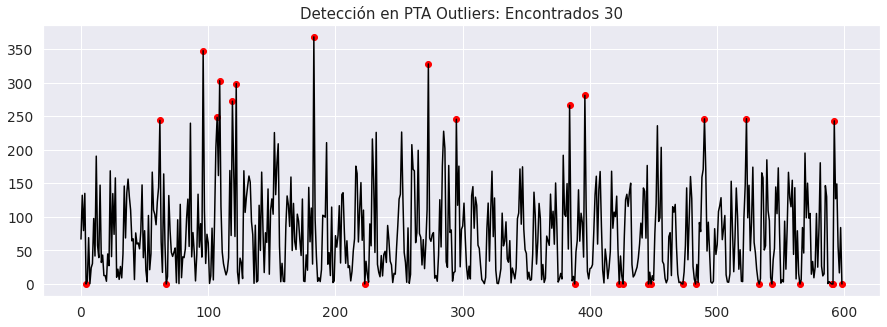

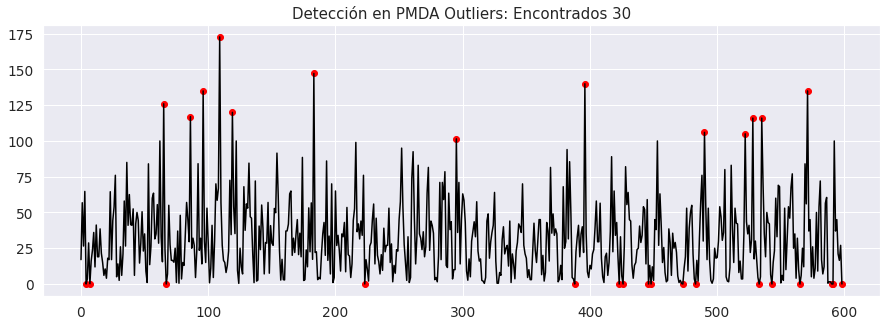

In [8]:
dtf_outliers_PTA = find_outliers(df.prcp_PTA, perc=0.05, var='PTA')
dtf_outliers_PMDA = find_outliers(df.prcp_PMDA, perc=0.05, var='PMDA')

- Filtrando los outliers:

In [9]:
df_o = df.copy()
columns_interest = ['prcp_PMDA', 'prcp_PTA']
df_o.loc[(dtf_outliers_PTA['outlier']==1) | (dtf_outliers_PMDA['outlier']==1), columns_interest] = np.nan
df_o[columns_interest] = df_o[columns_interest].interpolate(method="linear")
# df_o.prcp_PMDA.plot()

- Removiendo los datos atípicos PMDA (acortamos el periodo de visualizacion de los datos): 

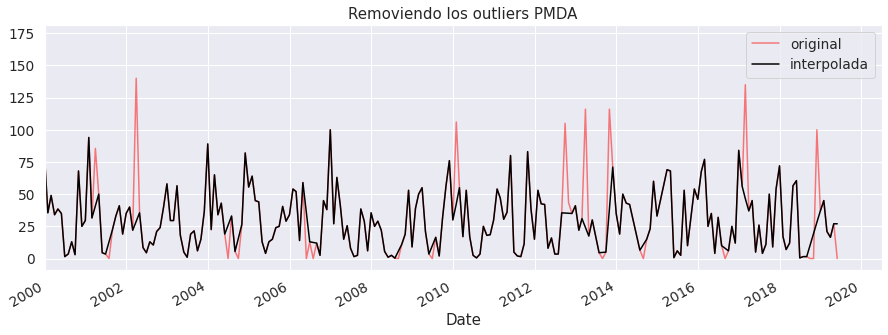

In [10]:

sinout_PMDA = df_o.groupby('Date')['prcp_PMDA'].sum() # serie sin datos atípicos PMDA
var = 'PMDA'
figsize=(15,5)
ax = ts_PMDA.plot(figsize=figsize, color="red", alpha=0.5,
         title=f"Removiendo los outliers {var}", label="original", legend=True)
sinout_PMDA.plot(ax=ax, grid=True, color="black",
                  label="interpolada", legend=True)
ax.set_xlim([date(2000, 1, 1), date(2020, 6, 30)])
plt.show()

- Removiendo los datos atípicos PTA (acortamos el periodo de visualizacion de los datos): 

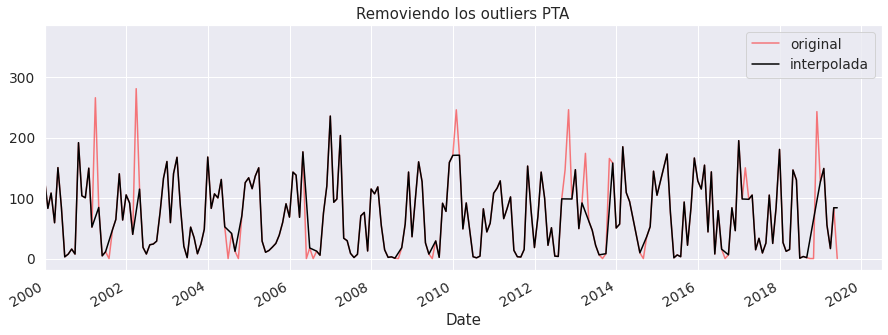

In [11]:
sinout_PTA = df_o.groupby('Date')['prcp_PTA'].sum() # serie sin datos atípicos PTA
var = 'PTA'
figsize=(15,5)

ax = ts_PTA.plot(figsize=figsize, color="red", alpha=0.5,
         title=f"Removiendo los outliers {var}", label="original", legend=True)
sinout_PTA.plot(ax=ax, grid=True, color="black",
                  label="interpolada", legend=True)
ax.set_xlim([date(2000, 1, 1), date(2020, 6, 30)])
plt.show()

- Copiamos el resultado en un Data frame e identificamos las variables que hacen parte del conjunto.

In [12]:
df = df_o.copy()

In [13]:
# Variables iniciales del conjunto:
df.columns

Index(['id', 'omm_id', 'hydro_year', 'Date', 'ETreal_mm', 'HumedadSuelo_mm',
       'IndicePalmer_porc', 'RadSolar_Wpm2', 'helio', 'hr', 'hr_max/mes',
       'hr_min/mes', 'prcp_PMDA', 'prcp_PTA', 'pres_est', 'td', 'tmax', 'tmed',
       'tmin', 'vmax_f', 'vmed'],
      dtype='object')

# Información importante Umbrales
      Índice de Palmer:


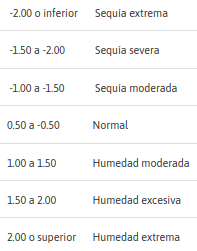

# Series de tiempo estacionarias:
Una serie de tiempo es considerada `estrictamente estacionaria` (es decir sus propiedades no son afectadas por los cambios a lo largo del tiempo) si cumple con tres criterios básicos :

- La *media de la serie no debe ser una función de tiempo*; sino que debe ser constante. 
- La *varianza de la serie no debe ser una función del tiempo*.
- La covarianza de la serie no debe ser una función del tiempo.  


La razón por la que estas series son importantes es que la mayoría de los modelos de series de tiempo funcionan bajo el supuesto de que la serie es estacionaria. Intuitivamente, podemos suponer que si una serie tiene un comportamiento particular en el tiempo, hay una probabilidad muy alta de que se comportamiento continúe en el futuro. 

Existen algunas maneras de determinar que una Serie temporal es estacionaria:
- `Visualmente`
- `Métodos locales`: Por ejemplo determinando la media/varianza en periodos distintos de tiempo y observando su comportamiento.
- `Test Estadísticos`: El test aumentado de Dickey-Fuller. 



* `Nota: Un proceso estacionario es un proceso estocástico cuya distribución de probabilidad conjunta no cambia cuando se desplaza en el tiempo. En consecuencia, los parámetros media y la varianza tampoco cambian con el tiempo, haciendo que las series temporales estacionarias sean fáciles de pronosticar`.


      Determinando visualmente si hay Estacionariedad:
          


` Nota: La serie de datos que venimos trabajando presenta una frecuencia mensual, vamos a visualizar los datos con dos ventanas temporales`. 

# Anualmente (12 meses):

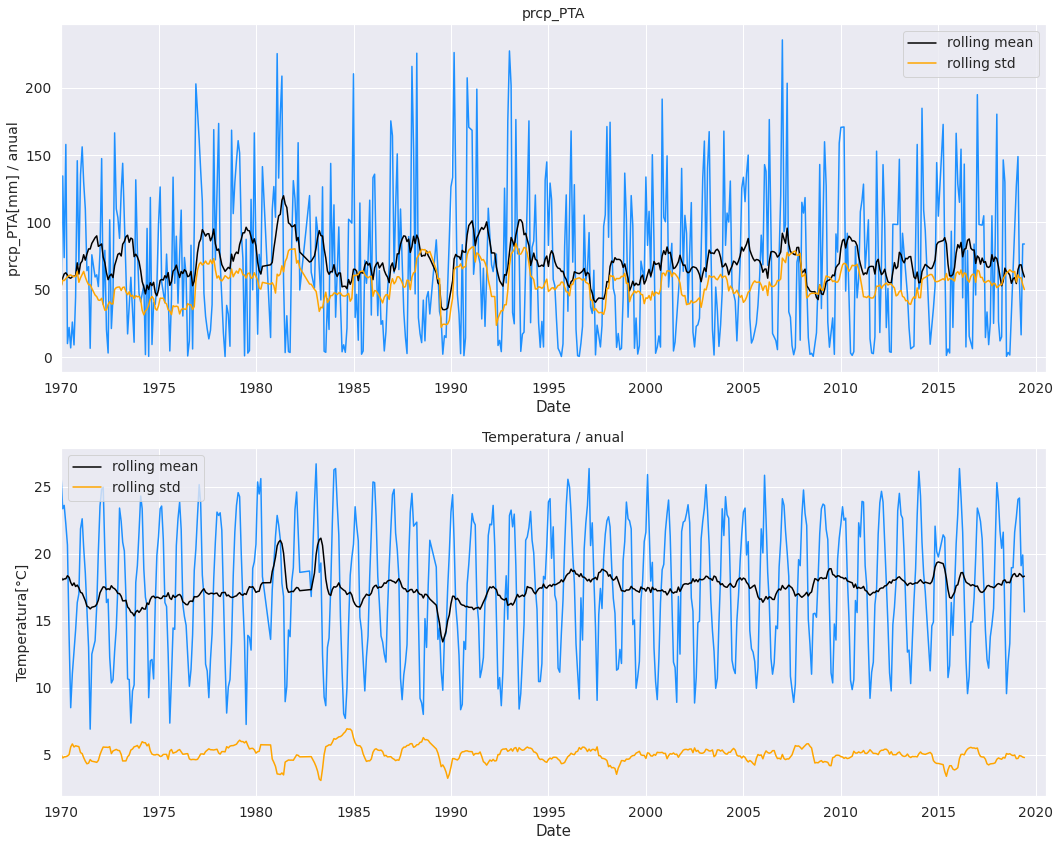

In [14]:
# A year 12 months
rolling_window = 12
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['prcp_PTA'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['prcp_PTA'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['prcp_PTA'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('prcp_PTA', fontsize=14)
ax[0].set_ylabel(ylabel='prcp_PTA[mm] / anual', fontsize=14)
ax[0].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])


sns.lineplot(x=df['Date'], y=df['tmed'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['tmed'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['tmed'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperatura / anual', fontsize=14)
ax[1].set_ylabel(ylabel='Temperatura[°C]', fontsize=14)
ax[1].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

# 5 Años (60 meses):

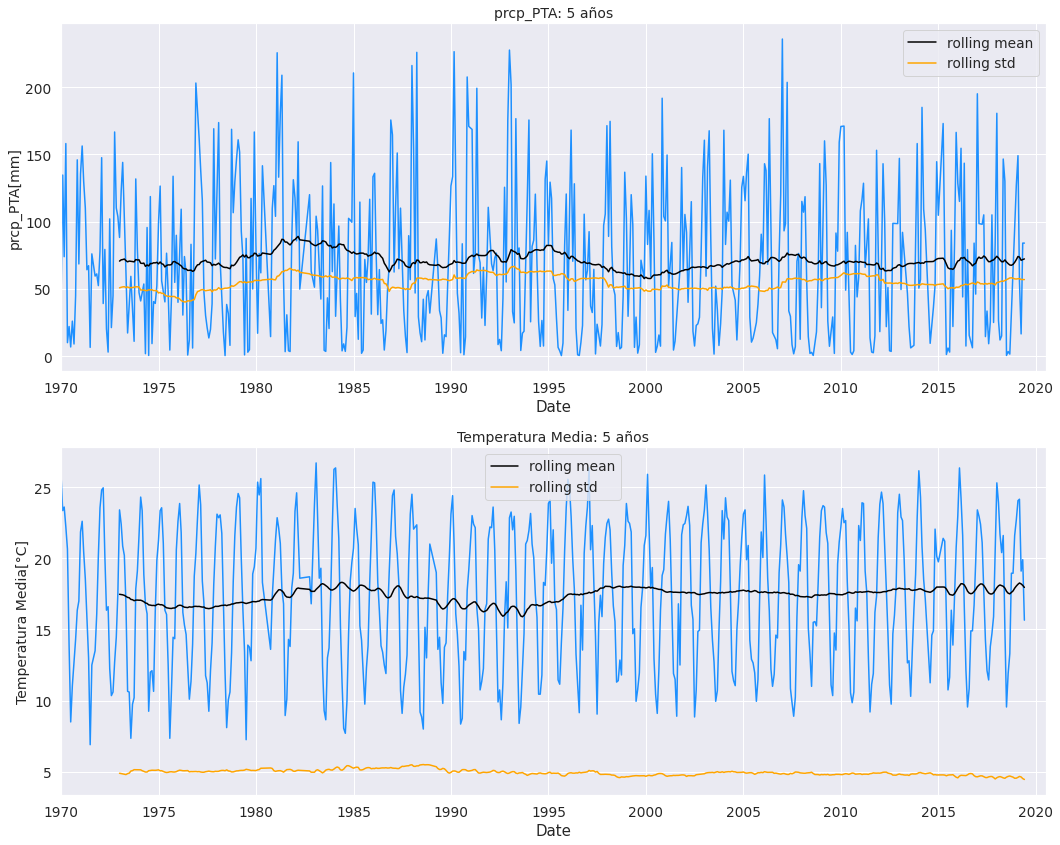

In [15]:
# A year 12 months
rolling_window = 60 # 5 años
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['prcp_PTA'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['prcp_PTA'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['prcp_PTA'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('prcp_PTA: 5 años', fontsize=14)
ax[0].set_ylabel(ylabel='prcp_PTA[mm]', fontsize=14)
ax[0].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])


sns.lineplot(x=df['Date'], y=df['tmed'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['tmed'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['tmed'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperatura Media: 5 años', fontsize=14)
ax[1].set_ylabel(ylabel='Temperatura Media[°C]', fontsize=14)
ax[1].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

En medida que se van tomando ventanas temporales más amplias tiende a mostrarnos que presente tendencia a la estacionalidad. Para comprobar si es estacional o no aplicaremos el `Test de Dickey-Fuller (adfuller)` disponible en la librería [stattools](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

    Test de Dickey-Fuller

La **hipótesis nula** del test de Dickey-Fuller *es que existe raíz unitaria (es decir, la serie no es estacionaria)*, mientras que la **hipótesis alternativa** es *que no hay raíz unitaria y por lo tanto la serie es estacionaria*. Entonces la hipótesis nula se puede rechazar comparando el valor p con un umbral elegido (α). Si el valor p es más pequeño, rechazamos y se podría suponer que la serie temporal es estacionaria con una confianza nivel de 1-α.





      Prueba de estacionariedad - prueba de Dickey-Fuller:
          


- Seleccionamos las columnas y usamos el código disponible en [Kaggle](https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide#4.-Exploratory-Data-Analysis-%F0%9F%93%8A):
  - PTA
  - PMDA
  - Temperatura  
  - Indice de Palmer 
  - ETreal_mm

In [16]:
cols=['id', 'omm_id', 'hydro_year', 'Date', 'ETreal_mm', 'HumedadSuelo_mm',
       'IndicePalmer_porc', 'RadSolar_Wpm2', 'helio', 'hr', 'hr_max/mes',
       'hr_min/mes', 'prcp_PMDA', 'prcp_PTA', 'pres_est', 'td', 'tmax', 'tmed',
       'tmin', 'vmax_f', 'vmed']

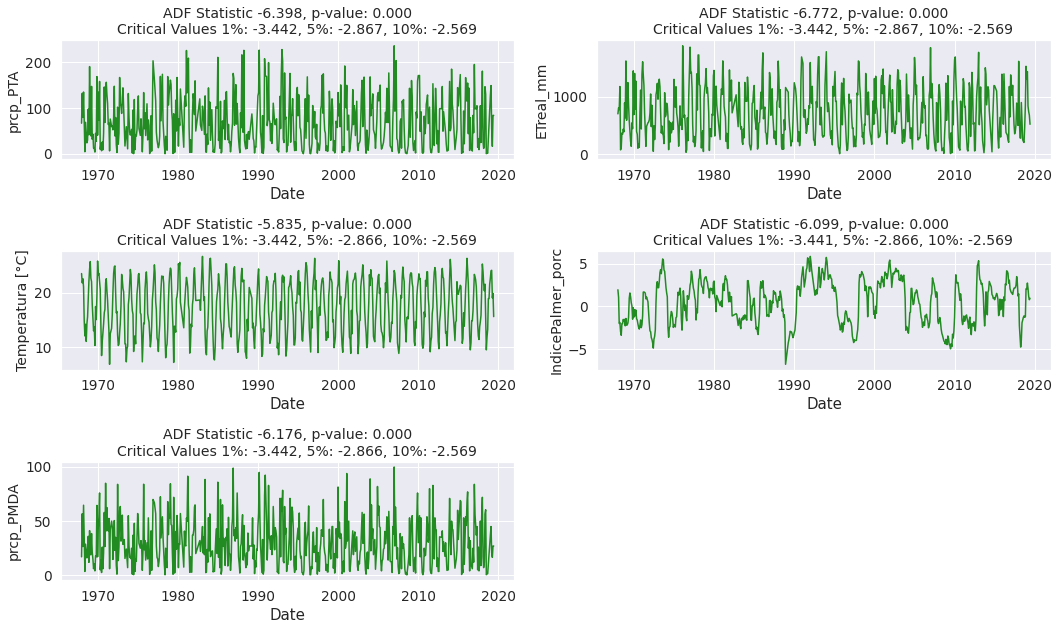

In [17]:
from statsmodels.tsa.stattools import adfuller
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['Date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\n\
    Critical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['prcp_PTA'].values, 'prcp_PTA', ax[0, 0])
visualize_adfuller_results(df['ETreal_mm'].values, 'ETreal_mm', ax[0, 1])

visualize_adfuller_results(df['tmed'].values, 'Temperatura [°C]', ax[1, 0])
visualize_adfuller_results(df['IndicePalmer_porc'].values, 'IndicePalmer_porc', ax[1, 1])

visualize_adfuller_results(df['prcp_PMDA'].values, 'prcp_PMDA', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()



**En conclusión:**
- Las series evaluadas son **Estacionarias.**

      Análisis de estacionalidad

Ahora bien una vez evaluamos que nuestras series son estacionarias y por ende pronosticables, nos centraremos en que compone a una serie de tiempo. El objetivo de esta sección sera el entender qué tipo de estacionalidad está afectando los datos. Es útil pensar una serie temporal como:
- Un conjunto de observaciones  $Y_{t}$  cada una recolectada en un tiempo específico $t$ [(Peter Brockwell, 2016)](https://www.kaggle.com/code/cesarg/taller-en-moldeamiento-series-de-tiempo).

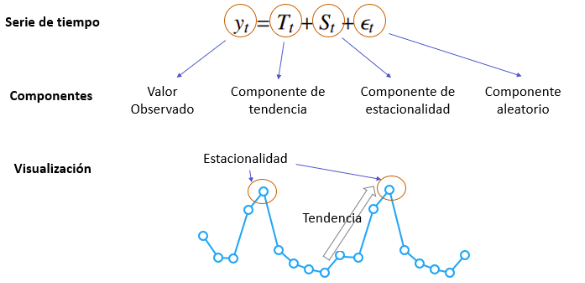

Como se ve en el grafico anterior es necesario pensar la serie como la suma de las componentes: tendencia, estacionalidad y ruido.

- **Tendencia:** valor creciente o decreciente de la serie.
-  **Estacionalidad (*Seasonal*):** ciclo repetitivo a corto plazo en la serie.
- **Residual:** variación aleatoria de la serie.

La descomposición nos permiten generalizar las series temporales y comprender la previsión de las series temporales. Descompondremos entonces las series y usaremos [seasonal_decompose()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) de la biblioteca statsmodels. Graficamos entonces la descomposición de la serie temporal para una estacionalidad de 12 meses.

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'prcp_PTA','prcp_PMDA','ETreal_mm', 
    'IndicePalmer_porc','tmed']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=12, model='additive', extrapolate_trend='freq')
    df[f"{column}_tendencia"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

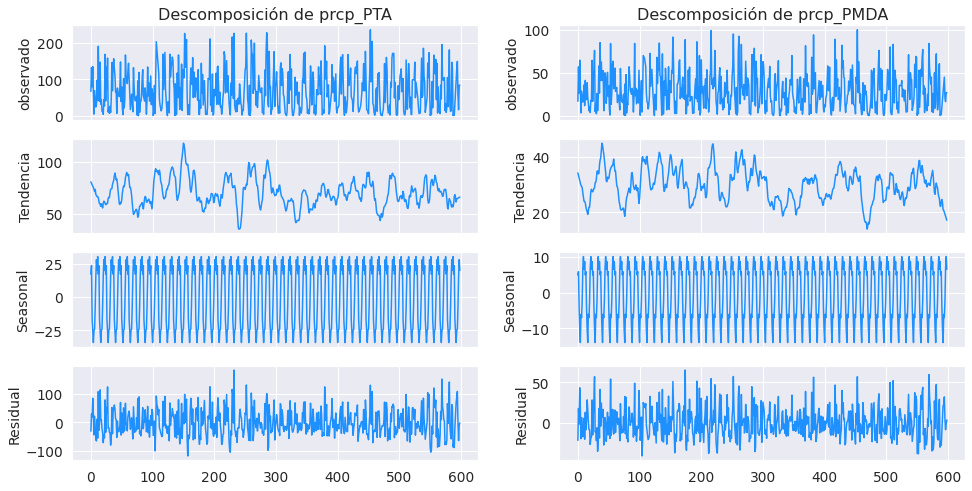

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['prcp_PTA', 'prcp_PMDA']):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Descomposición de {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('observado', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Tendencia', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()


      Desplazando los valores de la serie:




Una operación común en los datos de series de tiempo es desplazar los valores hacia atrás y adelante en el tiempo, para calcular el cambio de una muestra a otra, estas nos serviran para evaluar las correlaciones entre las variables estudiadas. Este desplazamiento en 

---

Pandas lo realizamos utilizando el método `.shift()`.

In [20]:
month = 1 

for column in core_columns:
    df[f'{column}_seasonal_shift_b_4m'] = df[f'{column}_seasonal'].shift(-4 * month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * month)

- Muestra de los valores anteriores en el dataframe:

In [21]:
df[['Date', 'prcp_PTA','prcp_PTA_seasonal', 'prcp_PTA_seasonal_shift_b_4m', \
    'prcp_PTA_seasonal_shift_1m','prcp_PTA_seasonal_shift_2m']].head(3)

,Date,prcp_PTA,prcp_PTA_seasonal,prcp_PTA_seasonal_shift_b_4m,prcp_PTA_seasonal_shift_1m,prcp_PTA_seasonal_shift_2m
0,1967-12-31,66.9,17.038037,-34.127343,NaN,NaN
1,1968-01-31,132.1,23.490422,-25.258946,17.038037,NaN
2,1968-02-29,79.5,-17.033694,-23.906867,23.490422,17.038037


- Características de las componentes estacionales:


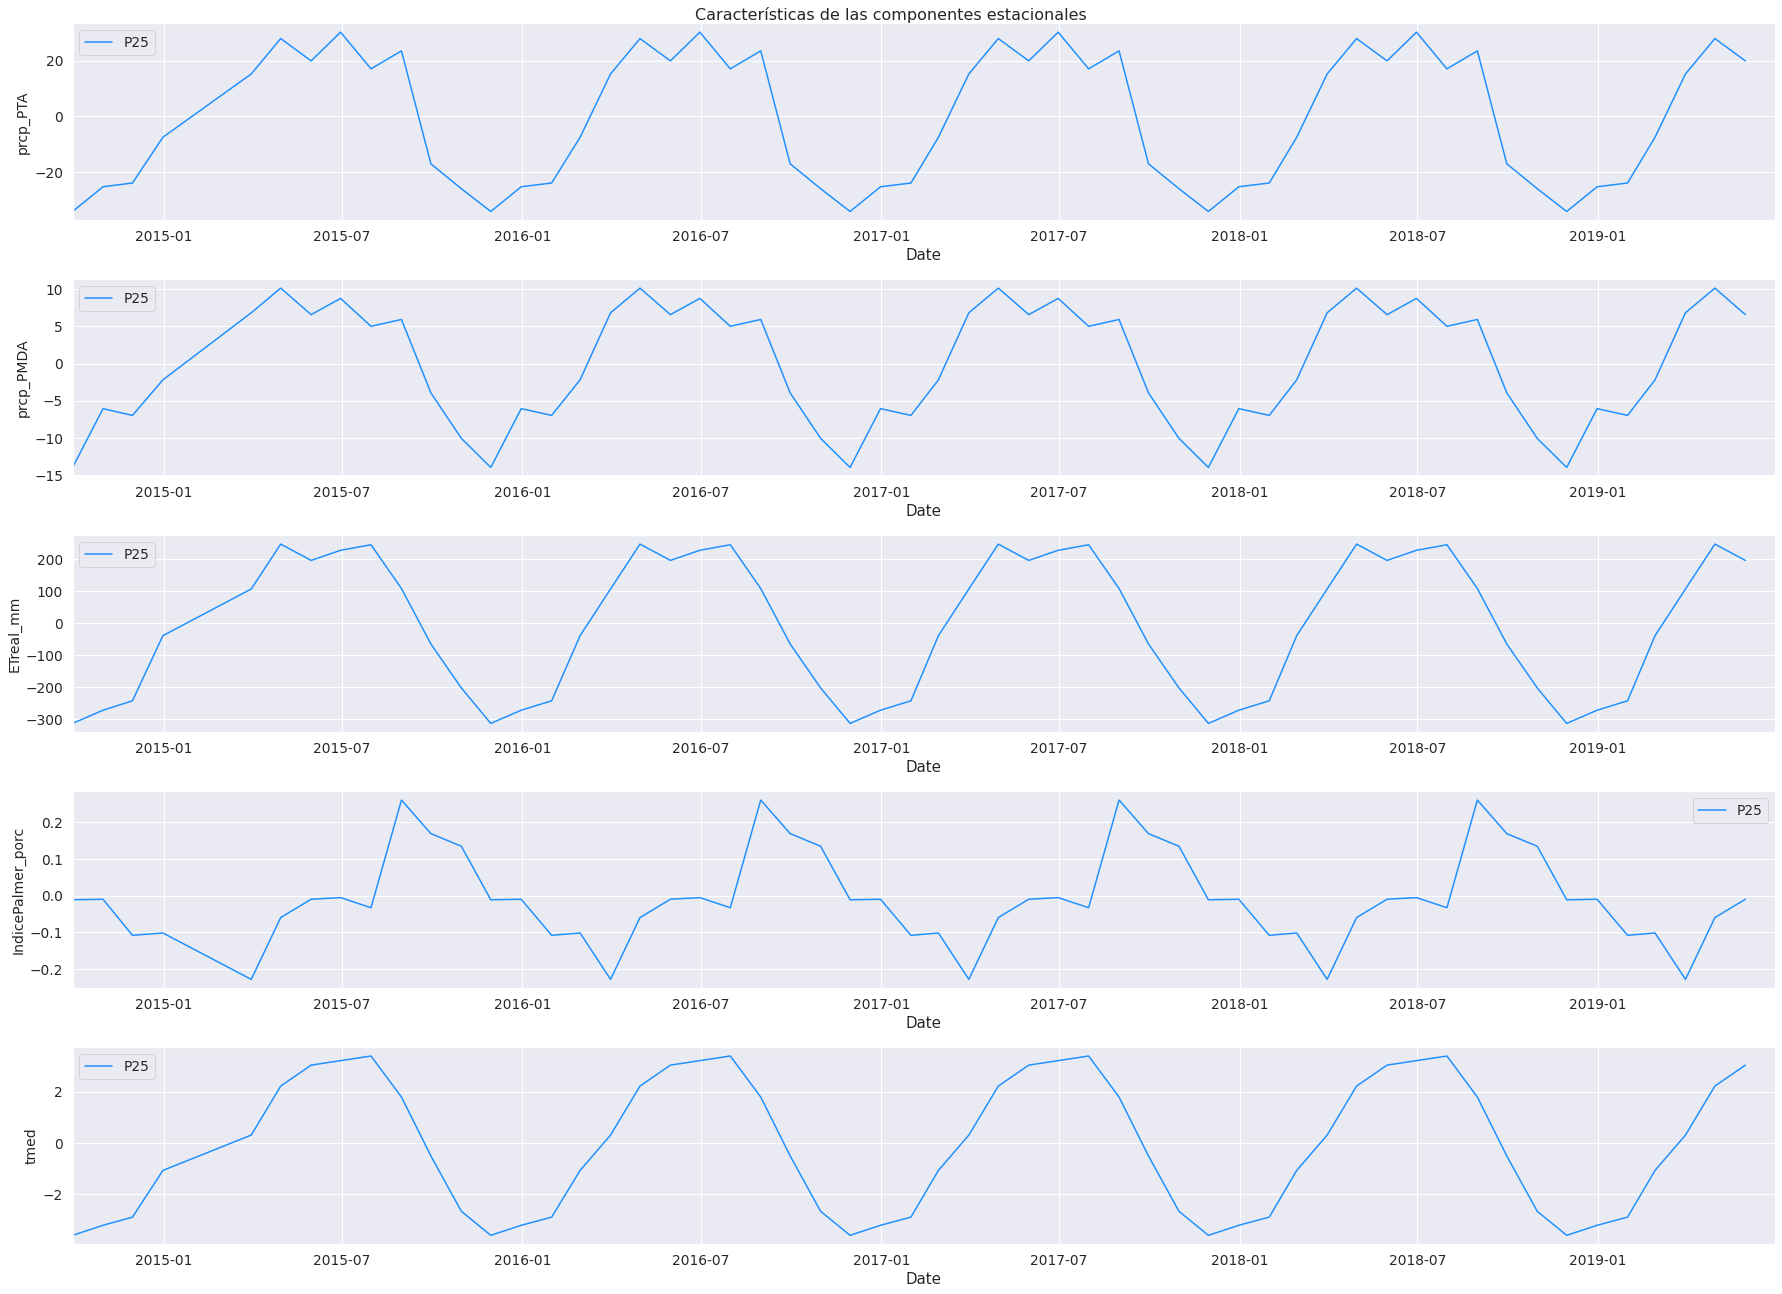

In [22]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(25, 18))
f.suptitle('Características de las componentes estacionales', fontsize=16, y=1.)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['Date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2014, 9, 30), date(2019, 6, 30)])
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    
plt.tight_layout()
plt.show()

De los anteriores puede inferirse que:
- PTA [mm/mes]: alcanza los maximos aprox. en Julio y sus minimos en Diciembre.
- PMDA [mm/mes]: alcanza los maximos aprox. en Mayo/Julio y sus minimos en Diciembre.
- ET real [mm/mes]: alcanza los maximos aprox. en Mayo/Agosto y sus minimos en Diciembre.
- Indice de Palmer (Efectos de la sequía): alcanza valores secos en en los meses de Septiembre y valores minimos en Abril.

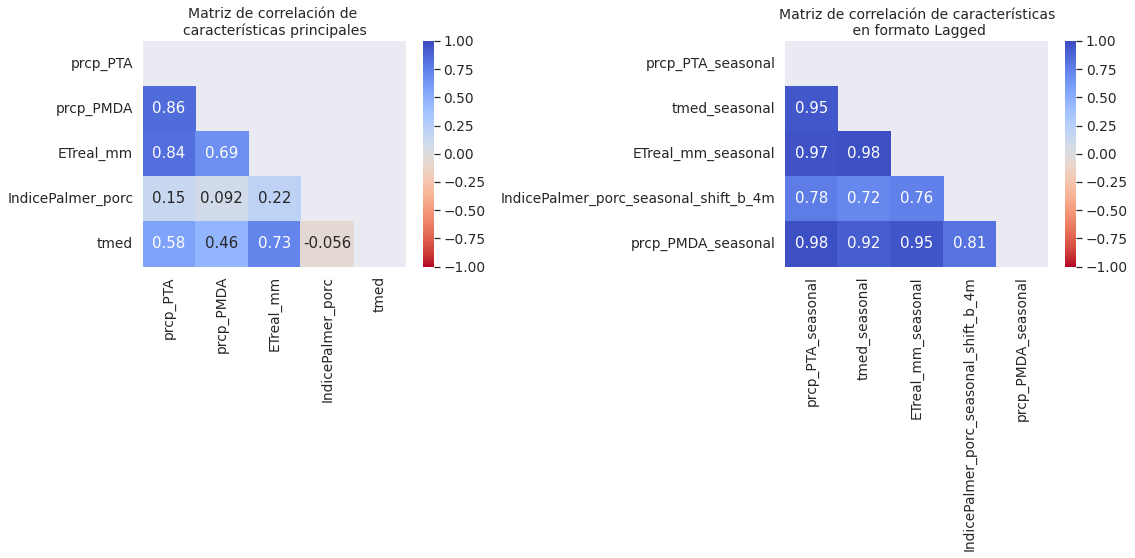

In [23]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()
mtx = np.triu(corrmat)
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0], mask=mtx)
ax[0].set_title('Matriz de correlación de \ncaracterísticas principales', fontsize=14)

shifted_cols = [
    'prcp_PTA_seasonal',         
    'tmed_seasonal',
    'ETreal_mm_seasonal', 
    'IndicePalmer_porc_seasonal_shift_b_4m',
    'prcp_PMDA_seasonal'
]
corrmat = df[shifted_cols].corr()
mtx2 = np.triu(corrmat)
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1], mask=mtx2)
ax[1].set_title('Matriz de correlación de características\n en formato Lagged', fontsize=14, y=0.7)


plt.tight_layout()
plt.show()


- Ahora bien, como se puede ver en las variables en formato retrasado (`lagged`) presentan mayor correlación que las variables originales. Sobretodo el indice de palmer.


      Promedios móviles y descomposición:
          


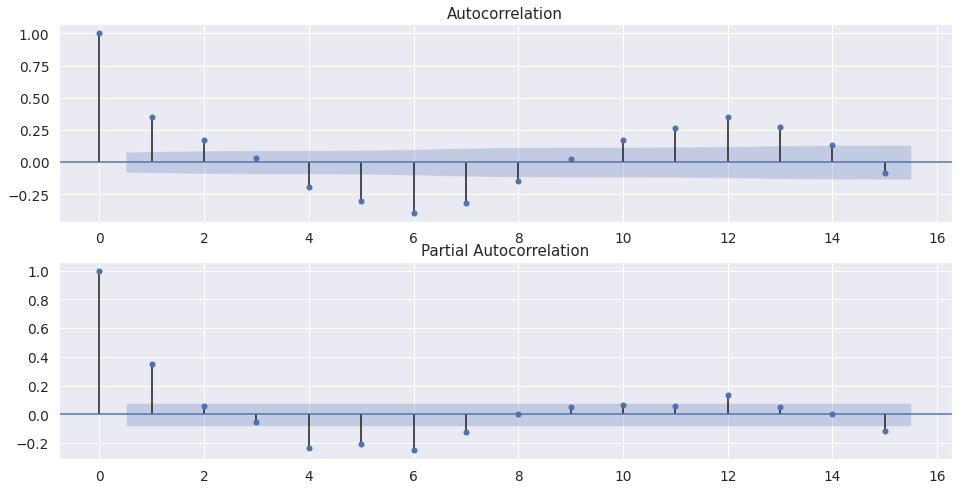

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['prcp_PTA'], lags=15, ax=ax[0])
plot_pacf(df['prcp_PTA'], lags=15, ax=ax[1])

plt.show()

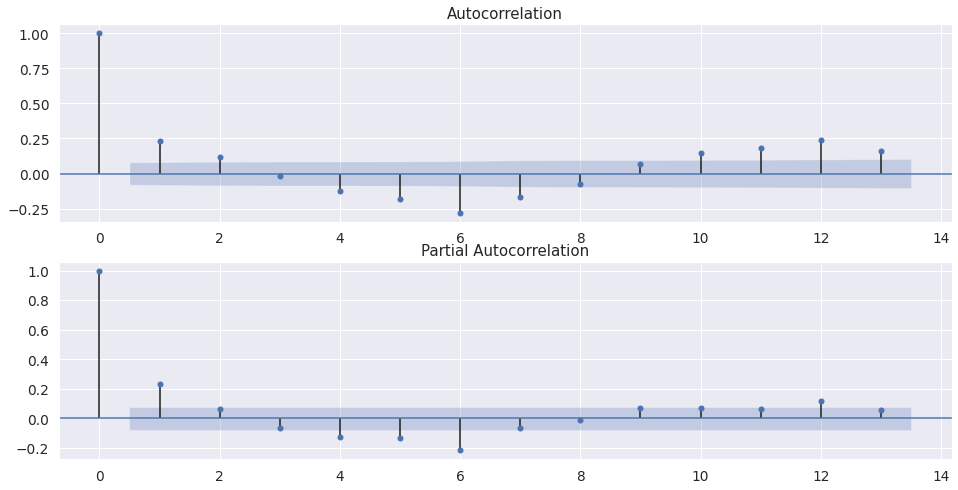

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['prcp_PMDA'], lags=13, ax=ax[0])
plot_pacf(df['prcp_PMDA'], lags=13, ax=ax[1])

plt.show()



      Modelamiento:
          


In [26]:
from sklearn.model_selection import TimeSeriesSplit


N_SPLITS = 3

X = df['Date']
y = df['prcp_PMDA']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

0 (152,) (149,)
3:152
1 (301,) (149,)
152:301
2 (450,) (149,)
301:450


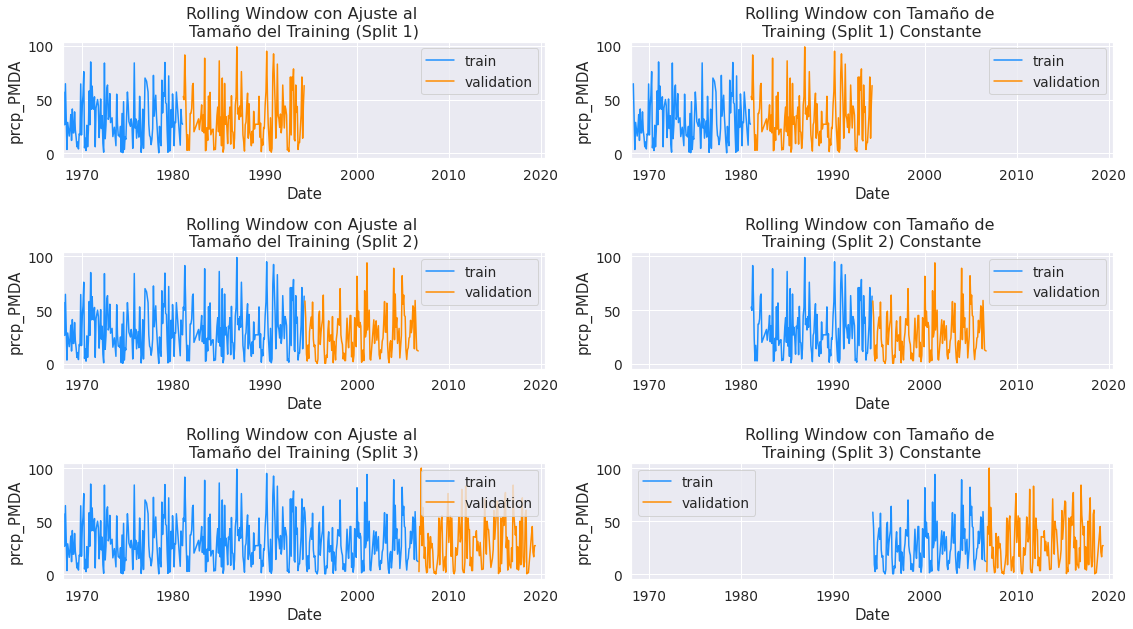

In [27]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print(i, X_train.shape, X_valid.shape)
    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    print(f'{len(X_train) - len(X_valid)}:{len(X_train)}')
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):len(X_train)], 
        y=y_train[len(X_train) - len(X_valid):len(X_train)], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window con Ajuste al \nTamaño del Training (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window con Tamaño de \nTraining (Split {i+1}) Constante", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(1968, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(1968, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()


      Modelamiento de series temporales univariantes
          



      Prophet:
          


In [28]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
train_size = int(0.89 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Date', 'prcp_PMDA']].copy()
univariate_df.columns = ['ds', 'y'] # Fecha y Dato

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))


533 66


In [30]:
univariate_df[train_size:].head(1)

,ds,y
533,2013-08-31,4.75


In [31]:
univariate_df[train_size:].tail(1)

,ds,y
598,2019-05-31,27.0


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

x_valid = model.make_future_dataframe(periods=test_size, freq='M')

# Predict on valid set
y_pred = model.predict(x_valid) #forecast

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 25.92663571451895


In [33]:
# Python
forecast = model.predict(y_pred)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
594,2018-09-30,22.674760,-1.618336,46.233671
595,2018-10-31,35.370629,13.482360,57.574562
596,2018-11-30,37.552779,15.039958,62.595799
597,2018-12-31,41.515105,19.669670,64.889992
598,2019-01-31,37.050787,12.741035,61.468468


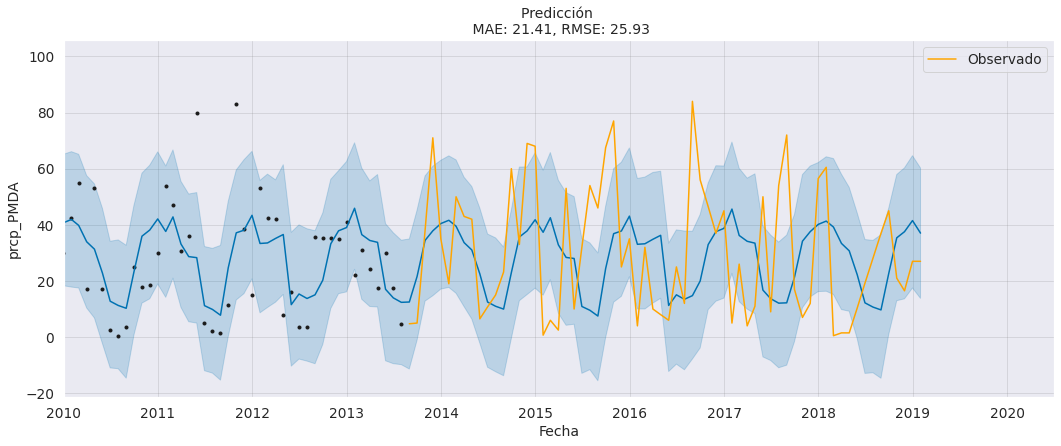

In [34]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Observado') #navajowhite

ax.set_title(f'Predicción \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Fecha', fontsize=14)
ax.set_ylabel(ylabel='prcp_PMDA', fontsize=14)

ax.set_xlim([date(2010, 1, 1), date(2020, 6, 30)])

plt.show()

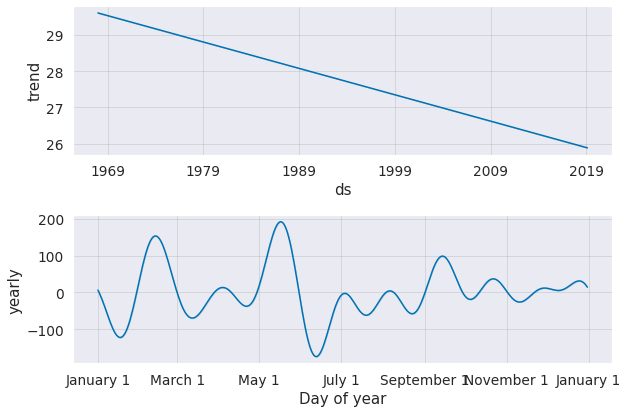

In [35]:

# Python
fig2 = model.plot_components(forecast)


In [36]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

                          LSTM

In [37]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.83249749],
       [-0.4332999 ],
       [-0.73721163],
       [-0.35406219],
       [-0.66098295],
       [-0.96790371],
       [-0.71514544],
       [-0.77883651],
       [-0.84252758],
       [-0.76730191]])

In [38]:
# Defines the rolling window
look_back = 12
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

509 66


In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()


Epoch 1/5
509/509 [==============================] - 9s 6ms/step - loss: 0.0604 - val_loss: 0.0469
Epoch 2/5
509/509 [==============================] - 2s 3ms/step - loss: 0.0489 - val_loss: 0.0458
Epoch 3/5
509/509 [==============================] - 2s 3ms/step - loss: 0.0446 - val_loss: 0.0461
Epoch 4/5
509/509 [==============================] - 2s 3ms/step - loss: 0.0449 - val_loss: 0.0454
Epoch 5/5
509/509 [==============================] - 2s 3ms/step - loss: 0.0444 - val_loss: 0.0514
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            72192     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                       

In [40]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print('RMSE: {}'.format(score_rmse))

RMSE: 22.614151708506462


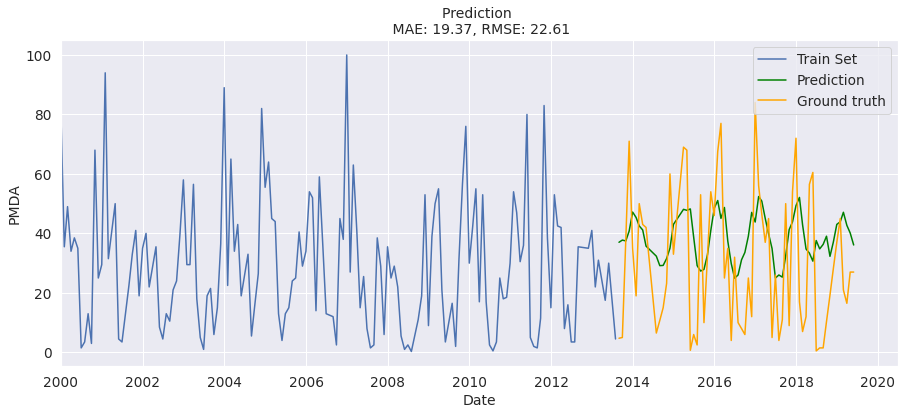

In [41]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='PMDA', fontsize=14)
ax.set_xlim([date(2000, 1, 1), date(2020, 6, 30)])

plt.show()


# 2) - 3) 
- Al verificar que tenemos la base de datos limpia de datos ausentes realizamos un agrupamiento por año hidrologico... con esta realizaremos el feature selection..

In [ ]:
# df.columns

In [ ]:
### Acumulado precipitación - Renombro:
datos_PTA_87466 = df[['hydro_year','omm_id','prcp_PTA']].groupby(['hydro_year', 'omm_id']).sum()

### Máximos por variable - PMDA - Renombro: 
datos_max_87466 = df[['hydro_year','omm_id','prcp_PMDA','hr_max/mes','tmax','vmax_f',\
                                   'pres_est','td']].groupby(['hydro_year', 'omm_id']).max()

datos_max_87466.rename(columns={'hr_max/mes':'hr_max','tmax':'tmax',\
                        'vmax_f':'vmax_f','pres_est':'pres_est_max',\
                        'td':'td_max'},inplace=True)                                   

### Mínimos por variable -  Renombro: 
datos_min_87466 = df[['hydro_year','omm_id','hr','tmin',
                                   'pres_est','td']].groupby(['hydro_year', 'omm_id']).min()

datos_min_87466.rename(columns={'hr':'hr_min','tmin':'tmin',\
                       'pres_est':'pres_est_min','td':'td_min'},
                     inplace=True)

                        
### Promedios por variable - Renombro: 
excepto =['id','Date','prcp_PMDA', 'prcp_PTA','tmax','vmax_d','vmax_f','hr_max/mes','hr_min/mes','tmin']
datos_prom_87466= round(df.loc[:, df. columns.difference(excepto)
                                                         ].groupby(['hydro_year', 'omm_id']).mean(),2)

datos_prom_87466.rename(columns={'ETreal_mm':'ETreal_mm_prom', 'HumedadSuelo_mm': 'HumedadSuelo_mm_prom',\
                               'IndicePalmer_porc':'IndicePalmer_porc_prom', 'RadSolar_Wpm2':'RadSolar_Wpm2_prom',\
                               'helio':'helio_prom','hr':'hr_prom','pres_est':'pres_est_prom',\
                              'td':'td_prom','tmed':'tmed','vmed':'vmed'},
                     inplace=True)


# Pegando los dataframe                     
df1= datos_PTA_87466.merge(datos_max_87466, on=['omm_id','hydro_year']) # PTA y maximos
df2 = df1.merge(datos_min_87466, on=['omm_id','hydro_year']) # PTA_maximos y minimos
d_87466 = df2.merge(datos_prom_87466, on=['omm_id','hydro_year']) # PTA_maximos_minimos_prom
d_87466.head(3) 

prcp_PTA  prcp_PMDA  hr_max  tmax  vmax_f  pres_est_max  \
omm_id hydro_year                                                            
87466  1967           418.1       64.7    78.0  39.0    4.12         19.64   
       1968           772.0       41.2    96.0  41.2    5.16         21.04   
       1969           708.6       76.0    95.0  39.7    5.20         21.35   

                   td_max  hr_min  tmin  pres_est_min  ...  ETreal_mm_prom  \
omm_id hydro_year                                      ...                   
87466  1967         14.95   50.94  -6.0         11.28  ...          607.50   
       1968         18.18   64.10  -3.0         10.00  ...          745.33   
       1969         16.64   50.23  -6.2          9.07  ...          674.25   

                   HumedadSuelo_mm_prom  IndicePalmer_porc_prom  \
omm_id hydro_year                                                 
87466  1967                       85.00                   -1.19   
       1968                      158.58                   -1.59   
       1969                      130.08                   -0.39   

                   RadSolar_Wpm2_prom  helio_prom  hr_prom  pres_est_prom  \
omm_id hydro_year                                                           
87466  1967                    220.92        8.40    54.96          16.43   
       1968                    188.09        7.08    71.08          14.67   
       1969                    189.24        7.39    63.20          14.56   

                   td_prom   tmed  vmed  
omm_id hydro_year                        
87466  1967          11.32  19.35  3.23  
       1968          13.29  18.70  3.29  
       1969          11.09  18.22  3.25  

[3 rows x 21 columns]

In [ ]:
d_87466.columns

Index(['prcp_PTA', 'prcp_PMDA', 'hr_max', 'tmax', 'vmax_f', 'pres_est_max',
       'td_max', 'hr_min', 'tmin', 'pres_est_min', 'td_min', 'ETreal_mm_prom',
       'HumedadSuelo_mm_prom', 'IndicePalmer_porc_prom', 'RadSolar_Wpm2_prom',
       'helio_prom', 'hr_prom', 'pres_est_prom', 'td_prom', 'tmed', 'vmed'],
      dtype='object')

# 4)
    Iniciaremos el procedimiento de Feature Selection.

In [ ]:
# creamos una copia del anterior
df_87466_mj = d_87466.copy()


- Visualizamos las correlaciones previamente con el fin de tener una idea de como se esta comportando el conjunto de datos en general:

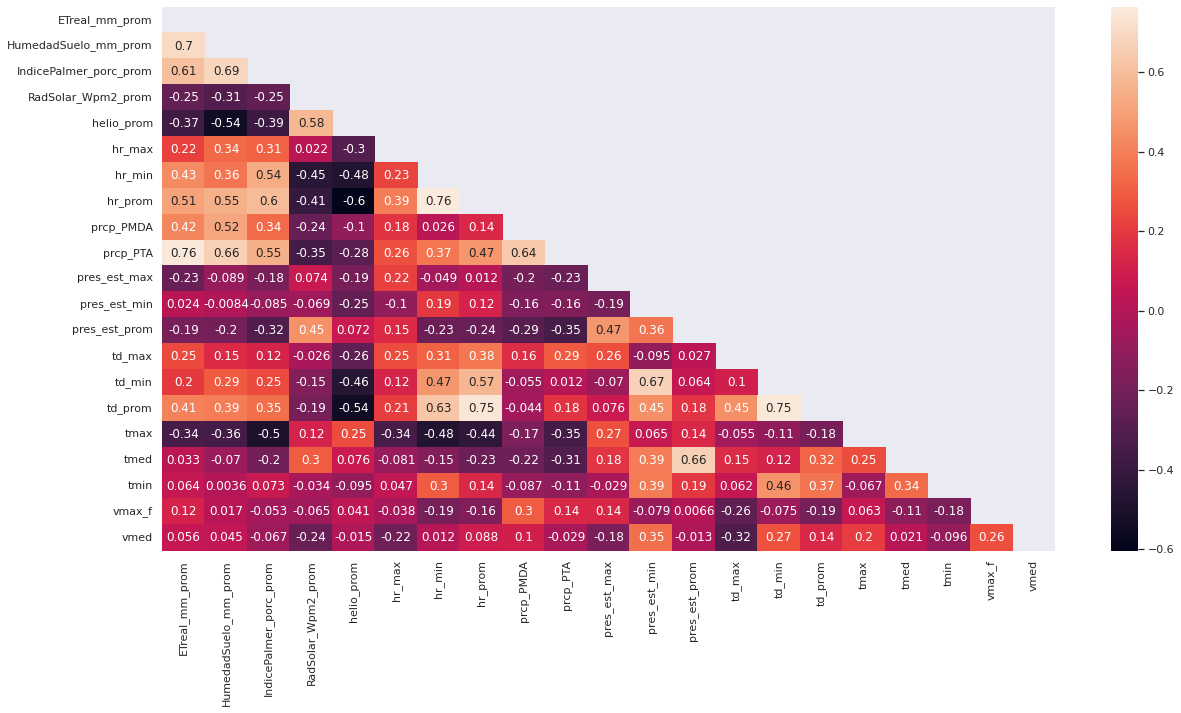

In [ ]:
df=df_87466_mj.loc[:,df_87466_mj.columns.difference(['id', 'omm_id', 'hydro_year', 'Date'])]


corr= df.corr(method='spearman')
matrix = np.triu(corr)
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, mask=matrix)


 Como es de esperar vemos algunas fuertes correlaciones entre la PMDA y PTA para el año hidrologico...

- Escalamos los datos:

In [ ]:
from sklearn.preprocessing import StandardScaler
excepto=['id', 'omm_id', 'hydro_year', 'Date','prcp_PMDA']
                                                        
x = df_87466_mj.loc[:,df_87466_mj.columns.difference(excepto)]
y_obs1 = df_87466_mj['prcp_PMDA'] 
# x.head(1)

# Escalado del conjunto de datos:
scaled_features = x.copy()
col_names = x.columns.tolist()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [ ]:
# control variables:
# print(scaled_features.columns.tolist())
print(x.columns.tolist())

['ETreal_mm_prom', 'HumedadSuelo_mm_prom', 'IndicePalmer_porc_prom', 'RadSolar_Wpm2_prom', 'helio_prom', 'hr_max', 'hr_min', 'hr_prom', 'prcp_PTA', 'pres_est_max', 'pres_est_min', 'pres_est_prom', 'td_max', 'td_min', 'td_prom', 'tmax', 'tmed', 'tmin', 'vmax_f', 'vmed']


In [ ]:
# X will be a pandas dataframe of all columns excepto - > ['id', 'omm_id', 'hydro_year', 'Date','prcp_PMDA']
x = scaled_features[[col for col in scaled_features.columns]]
# Vector con valores esperados
scaled_features[col_names] = features
scaled_features.head(3)

ETreal_mm_prom  HumedadSuelo_mm_prom  \
omm_id hydro_year                                         
87466  1967             -1.133737             -1.298044   
       1968              0.287454             -0.069698   
       1969             -0.445465             -0.545477   

                   IndicePalmer_porc_prom  RadSolar_Wpm2_prom  helio_prom  \
omm_id hydro_year                                                           
87466  1967                     -0.897938            2.296085    2.480421   
       1968                     -1.110880           -1.199696   -0.244985   
       1969                     -0.472055           -1.077243    0.395073   

                     hr_max    hr_min   hr_prom  prcp_PTA  pres_est_max  \
omm_id hydro_year                                                         
87466  1967       -5.913983 -1.386256 -3.777526 -2.182856     -0.380193   
       1968       -0.087153  1.100683  0.477457 -0.433750      0.191431   
       1969       -0.410866 -1.520430 -1.602522 -0.747097      0.318005   

                   pres_est_min  pres_est_prom    td_max    td_min   td_prom  \
omm_id hydro_year                                                              
87466  1967            2.824825       3.985852 -2.797641 -0.769603 -1.008070   
       1968            1.062355       0.595025 -0.378885  0.691032  1.068895   
       1969           -0.218190       0.383098 -1.532100 -0.549997 -1.250559   

                       tmax      tmed      tmin    vmax_f      vmed  
omm_id hydro_year                                                    
87466  1967        0.538357  2.007127 -0.197893 -0.994480  1.290198  
       1968        1.727315  1.307520  1.330388  0.865183  1.394240  
       1969        0.916662  0.790887 -0.299778  0.936709  1.324878

In [ ]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression


from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
def result_iteracion(features,scores,color,metodo,criterio):

  sns.set(style=color)
  x = features.columns.tolist()
  y = scores
  
  pairs = zip(x, y)
  pairs= sorted(pairs, key=lambda x: x[1], reverse= True)
  plt.xticks(rotation=90)
    
  newx, newy = zip(*pairs)
  
  ax = sns.barplot(x=list(newx), y=list(newy))
  ax.set_title(f'{metodo}',  fontsize = 12)
  plt.ylabel(f'{criterio} Feature Scores')
  plt.show()


  # Almacenando los reportes:
 
  for newx, newy in pairs:
    print(f'score: {newy:0.2f} - var: {newx}')


In [ ]:
# Feature selection
KB_fs = SelectKBest(score_func = f_regression, k="all").fit(x, y_obs1)
scores_fr =  KB_fs.scores_


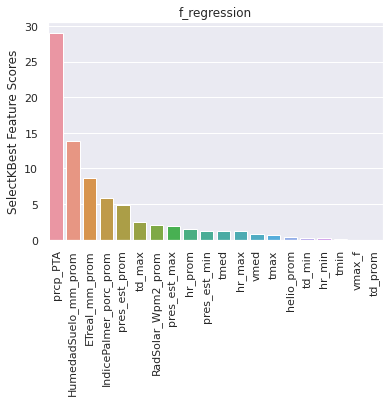

score: 29.06 - var: prcp_PTA
score: 13.91 - var: HumedadSuelo_mm_prom
score: 8.66 - var: ETreal_mm_prom
score: 5.90 - var: IndicePalmer_porc_prom
score: 4.82 - var: pres_est_prom
score: 2.43 - var: td_max
score: 2.10 - var: RadSolar_Wpm2_prom
score: 1.87 - var: pres_est_max
score: 1.48 - var: hr_prom
score: 1.27 - var: pres_est_min
score: 1.22 - var: tmed
score: 1.16 - var: hr_max
score: 0.80 - var: vmed
score: 0.68 - var: tmax
score: 0.39 - var: helio_prom
score: 0.28 - var: td_min
score: 0.27 - var: hr_min
score: 0.07 - var: tmin
score: 0.01 - var: vmax_f
score: 0.00 - var: td_prom


In [ ]:
#show_results(x, scores)
# Aplicando la funcion 
result_iteracion(x,scores_fr,color = "darkgrid", metodo = 'f_regression', criterio ='SelectKBest')

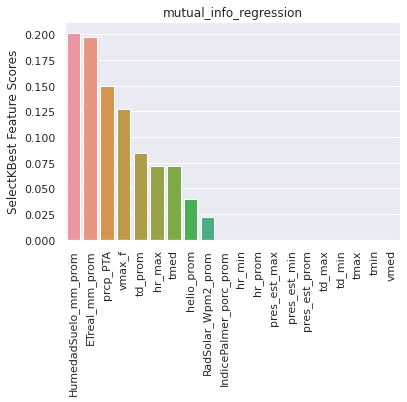

score: 0.20 - var: HumedadSuelo_mm_prom
score: 0.20 - var: ETreal_mm_prom
score: 0.15 - var: prcp_PTA
score: 0.13 - var: vmax_f
score: 0.08 - var: td_prom
score: 0.07 - var: hr_max
score: 0.07 - var: tmed
score: 0.04 - var: helio_prom
score: 0.02 - var: RadSolar_Wpm2_prom
score: 0.00 - var: IndicePalmer_porc_prom
score: 0.00 - var: hr_min
score: 0.00 - var: hr_prom
score: 0.00 - var: pres_est_max
score: 0.00 - var: pres_est_min
score: 0.00 - var: pres_est_prom
score: 0.00 - var: td_max
score: 0.00 - var: td_min
score: 0.00 - var: tmax
score: 0.00 - var: tmin
score: 0.00 - var: vmed


In [ ]:
# los métodos de información mutua pueden capturar cualquier tipo de dependencia estadística, 
# pero al no ser paramétricos, requieren más muestras para una estimación precisa.

KB_fs_mr  = SelectKBest(score_func=mutual_info_regression, k="all").fit(x, y_obs1)
scores_mr =  KB_fs_mr .scores_
# Aplicando la funcion 

result_iteracion(x,scores_mr,color = "darkgrid", metodo = 'mutual_info_regression', criterio ='SelectKBest')

# Dados los puntajes anteriores - seleccionamos las siguientes variables para predecir la PMDA:
- score: 0.20 - var: HumedadSuelo_mm_prom
- score: 0.20 - var: ETreal_mm_prom
- score: 0.15 - var: prcp_PTA
- score: 0.13 - var: vmax_f
- score: 0.08 - var: td_prom
- score: 0.07 - var: hr_max
- score: 0.07 - var: tmed
- score: 0.04 - var: helio_prom



# 5)

- División del conjunto de datos:

In [ ]:
# from sklearn.model_selection import train_test_split
# X, y = boston['data'], boston['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
# X_train.shape, X_test.shape

Aca inicia:
- https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205

- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/time_series/example_forecast.ipynb


Busqueda en internet:

https://towardsdatascience.com/predicting-rain-with-machine-learning-2acf80017c44

https://www.kaggle.com/code/nasirmeh/prediction-of-rainfall

https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy

https://www.kaggle.com/code/chandrimad31/rainfall-prediction-7-popular-models